## Import packages

In [18]:
%load_ext autoreload
%autoreload 2

import sys, pickle, time,os, re, boto3,unicodedata, codecs,nltk,gensim,itertools,spacy,joblib, numpy as np, pandas as pd
#start_time = time.time()
#np.random.seed(32)
#os.environ["OMP_NUM_THREADS"] = "4"
#sys.setdefaultencoding('utf8')

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.metrics import f1_score

from utility.normalization import normalize_corpus
from utility.feature_extractors import bow_extractor, tfidf_extractor, averaged_word_vectorizer, tfidf_weighted_averaged_word_vectorizer
from utility.helper_functions import prepare_datasets,remove_empty_docs, get_metrics, show_confusion_matrix

from collections import defaultdict
import seaborn as sn
from IPython.display import display, HTML
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
nlp = spacy.load('en')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [19]:
data_path = 'data/ig_open_source/claims_opensource.csv'
supported_category = ["Claims/deductible","Claims/file_claim"]
#read corpus
corpus = pd.DataFrame()
corpus = pd.read_csv(data_path)
corpus = corpus.drop_duplicates(subset=['text'],keep='first')
print('Total Data (after duplicate)',corpus.shape[0])
assert (len(corpus['category'].unique()) == 2)
corpus.shape

('Total Data (after duplicate)', 85)


(85, 2)

## Data Analysis

### Category Distribution

       category name  count  percentage
0  Claims/deductible     46   54.117647
1  Claims/file_claim     39   45.882353


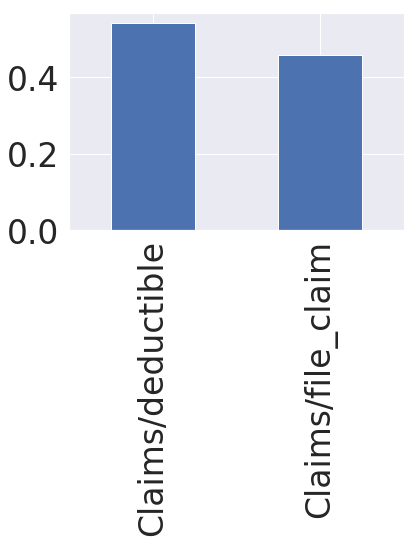

In [20]:
category_count=corpus['category'].value_counts()
category_percentage= corpus['category'].value_counts(normalize=True) * 100
category_df = pd.DataFrame(data = {'category name':category_count.index,'count':category_count.values,'percentage':category_percentage.values})
print(category_df)

corpus['category'].value_counts(normalize=True).plot(kind='bar')

### Word Distribution

    bins  counts
0   0-10      64
1  10-20      18
2  20-30       1
3  30-60       2
4  60-90       0


Text(0.5,1,'Word distribution per bin')

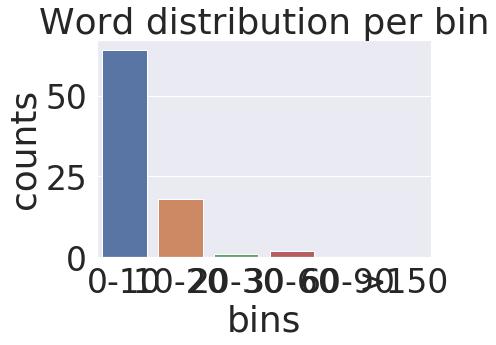

In [22]:
corpus['num_words'] = corpus['text'].apply(lambda x : len(x.split()))

bins=[0,10,20,30,60,90,120,150,np.inf]
corpus['bins']=pd.cut(corpus['num_words'], bins=[0,10,20,30,60,90,np.inf], labels=['0-10','10-20','20-30', '30-60', '60-90' ,'>150'])

word_distribution = corpus.groupby('bins').size().reset_index().rename(columns={0:'counts'})

print(word_distribution.head())
sn.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

## Corpus Normalization

In [23]:
corpus, labels = list(corpus['text']), list(corpus['category'])
corpus, labels = remove_empty_docs(corpus, labels)

print('Sample document:', corpus[10])
print('Class label:',labels[10])


train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(corpus,
                                                                        labels,
                                                                        test_data_proportion=0.10)

('Sample document:', 'my sons phone was stolen')
('Class label:', 'Claims/file_claim')


In [24]:
def get_normalized_data(cache_dir, cache_file):
    cache_data = dict()
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                normalized_data = pickle.load(f)
                cache_data['normalized_train_data'] = normalized_data['normalized_train_data']
                print("Read normalized train data from cache file:", cache_file)
                cache_data['normalized_test_data'] = normalized_data['normalized_test_data']
                print("Read normalized test data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay

    # If cache is missing, then do the heavy lifting
    if len(cache_data) < 2:
        # # Preprocess training and test data to obtain words for each review
        norm_train_corpus = normalize_corpus(train_corpus,classifier = 'top_level',text_stemming=False)
        norm_test_corpus = normalize_corpus(test_corpus,classifier = 'top_level',text_stemming=False)
        print('reading new data')
        
        if cache_file is not None:
            cache_data = dict(normalized_train_data=norm_train_corpus,normalized_test_data=norm_test_corpus)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote Normalized data to cache files:", cache_file)
    else:
        # Unpack data loaded from cache file
        norm_train_corpus= cache_data['normalized_train_data']
        norm_test_corpus= cache_data['normalized_test_data']
    
    return norm_train_corpus, norm_test_corpus
    
cache_dir = os.path.join("cache", "normalized_data")  # where to store cache files
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)  # ensure cache directory exists
norm_train_corpus, norm_test_corpus= get_normalized_data(cache_dir,cache_file='normalized_open_source_data.pkl')

reading new data
('Wrote Normalized data to cache files:', 'normalized_open_source_data.pkl')


In [25]:
train_corpus[:5]

['Need my glass replaced',
 'Online insurance claim',
 'iPhone 6 not working of my son , how much is deductible',
 'How much is my deductible',
 'The line ending in 6468 has a very cracked screen.  How much would it be to fix?']

In [26]:
norm_train_corpus[:5]

[u'need glass replace',
 u'online insurance claim',
 u'iphone not work how much deductible',
 u'how much deductible',
 u'line end crack screen how much fix']

## Word Embeddings

In [27]:
# bag of words features
bow_vectorizer, bow_train_features = bow_extractor(norm_train_corpus,ngram_range=(1,2))  
bow_test_features = bow_vectorizer.transform(norm_test_corpus) 

# tfidf features
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(norm_train_corpus,ngram_range=(1,2))  
tfidf_test_features = tfidf_vectorizer.transform(norm_test_corpus)    


# tokenize documents
tokenized_train = [nltk.word_tokenize(text)
                   for text in norm_train_corpus]
tokenized_test = [nltk.word_tokenize(text)
                   for text in norm_test_corpus]  

In [28]:
from sklearn.linear_model import LogisticRegression

lr = SGDClassifier()
param_grid = { 
    'loss': [#'hinge',
             #'log',
            'modified_huber'
            ],
    'penalty': ['l2','elasticnet'], #l1
    'max_iter':[1000,2000],

}

#skf = StratifiedKFold(n_splits=10)
CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv= 10)
CV_lr.fit(tfidf_train_features, train_labels)
predicted_lr = CV_lr.predict(tfidf_test_features)
print('Cross validation score:',CV_lr.best_score_)
get_metrics(true_labels=test_labels, 
                predicted_labels=predicted_lr)
# print best parameters
print(CV_lr.best_params_)
print(metrics.classification_report(test_labels,predicted_lr))

('Cross validation score:', 0.868421052631579)
('Accuracy:', 1.0)
('Precision:', 1.0)
('Recall:', 1.0)
('F1 Score:', 1.0)
{'penalty': 'elasticnet', 'loss': 'modified_huber', 'max_iter': 1000}
                   precision    recall  f1-score   support

Claims/deductible       1.00      1.00      1.00         5
Claims/file_claim       1.00      1.00      1.00         4

        micro avg       1.00      1.00      1.00         9
        macro avg       1.00      1.00      1.00         9
     weighted avg       1.00      1.00      1.00         9



/home/ubuntu/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Decide the model

In [29]:
model = CV_lr
predicted = predicted_lr
featex = tfidf_vectorizer
labels_map = {k: v for k,v in enumerate(model.classes_)}

## Confusion Matrix

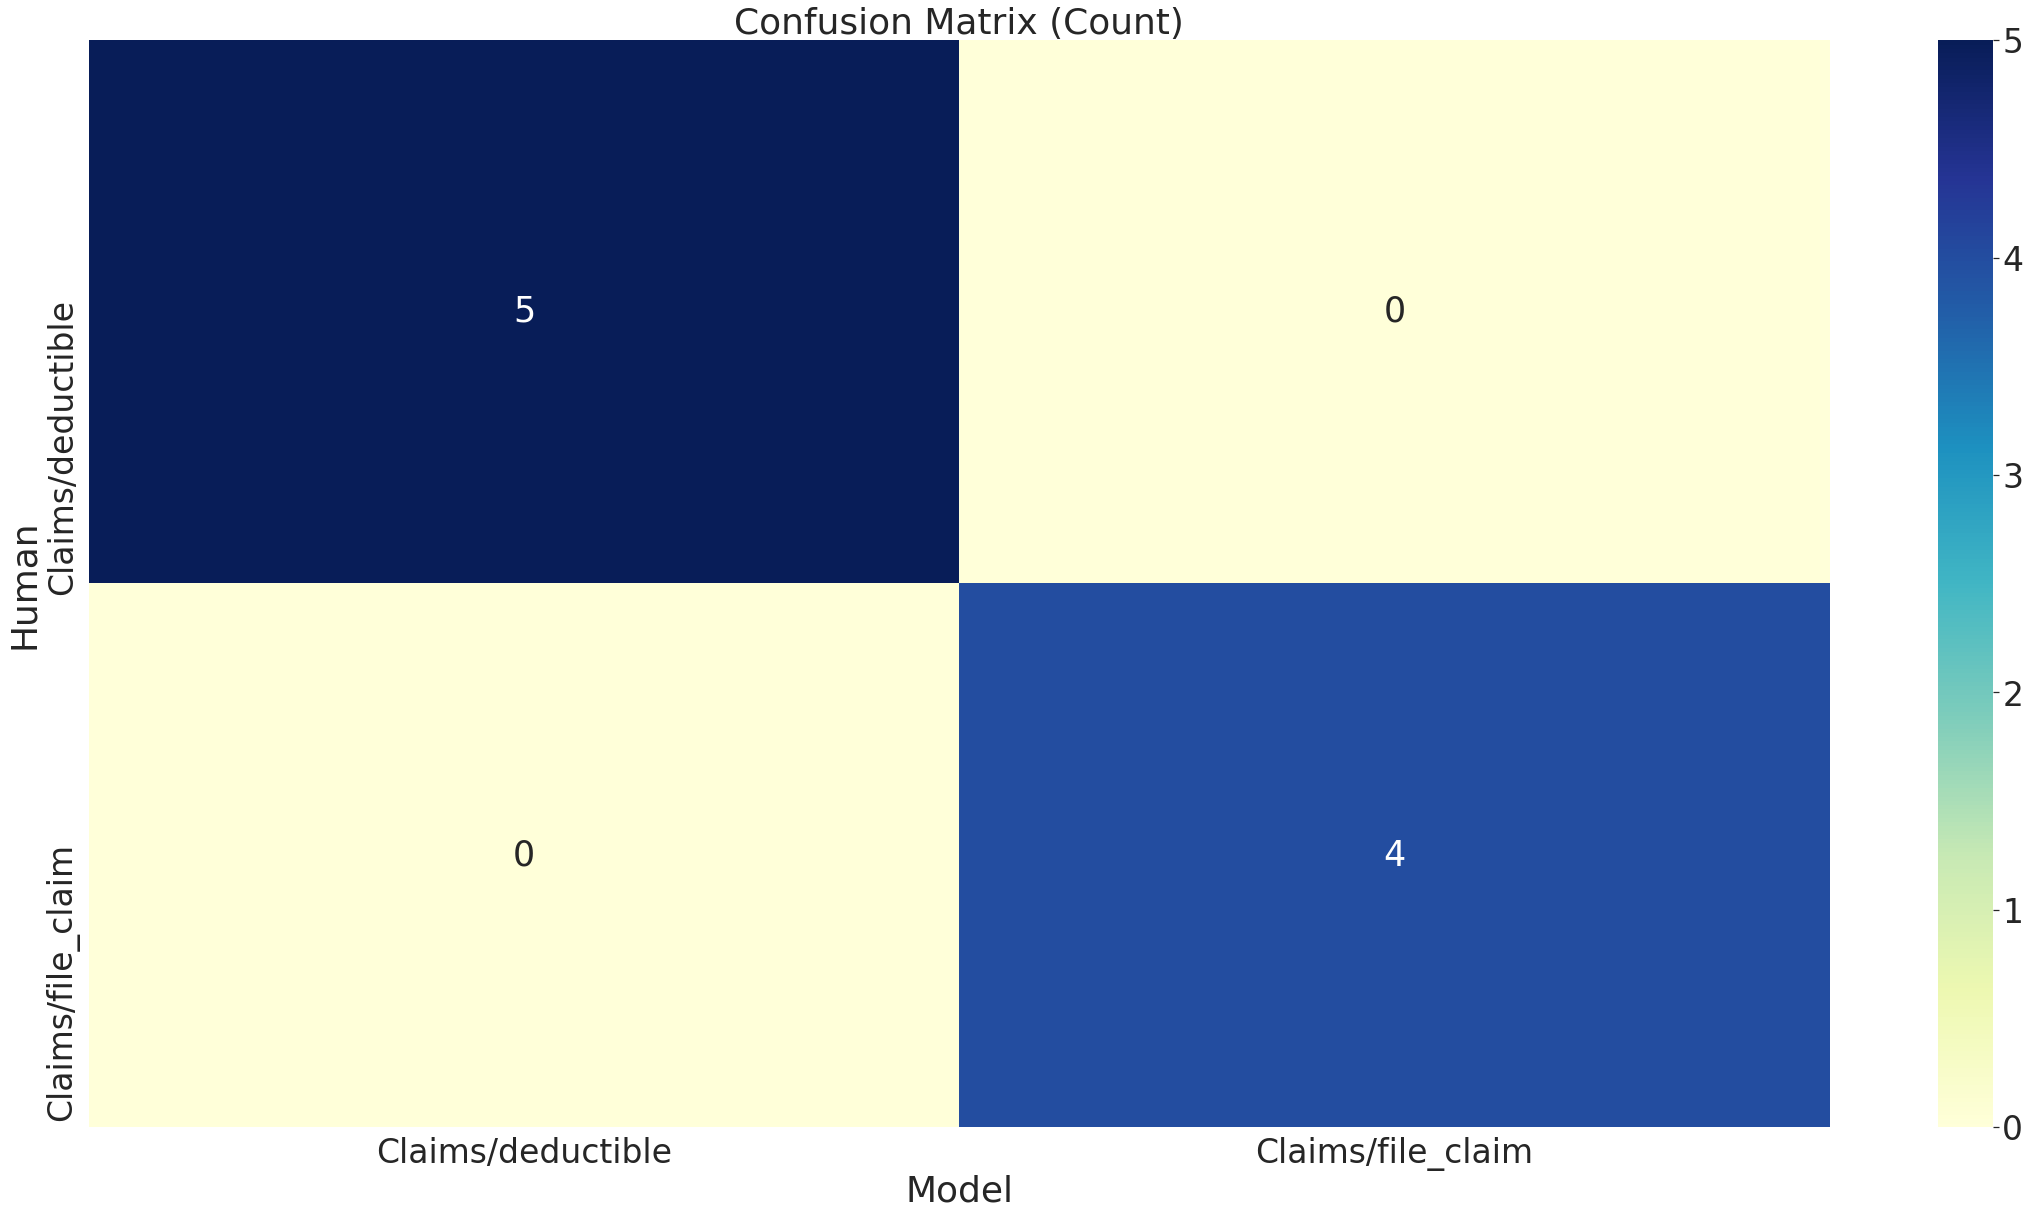

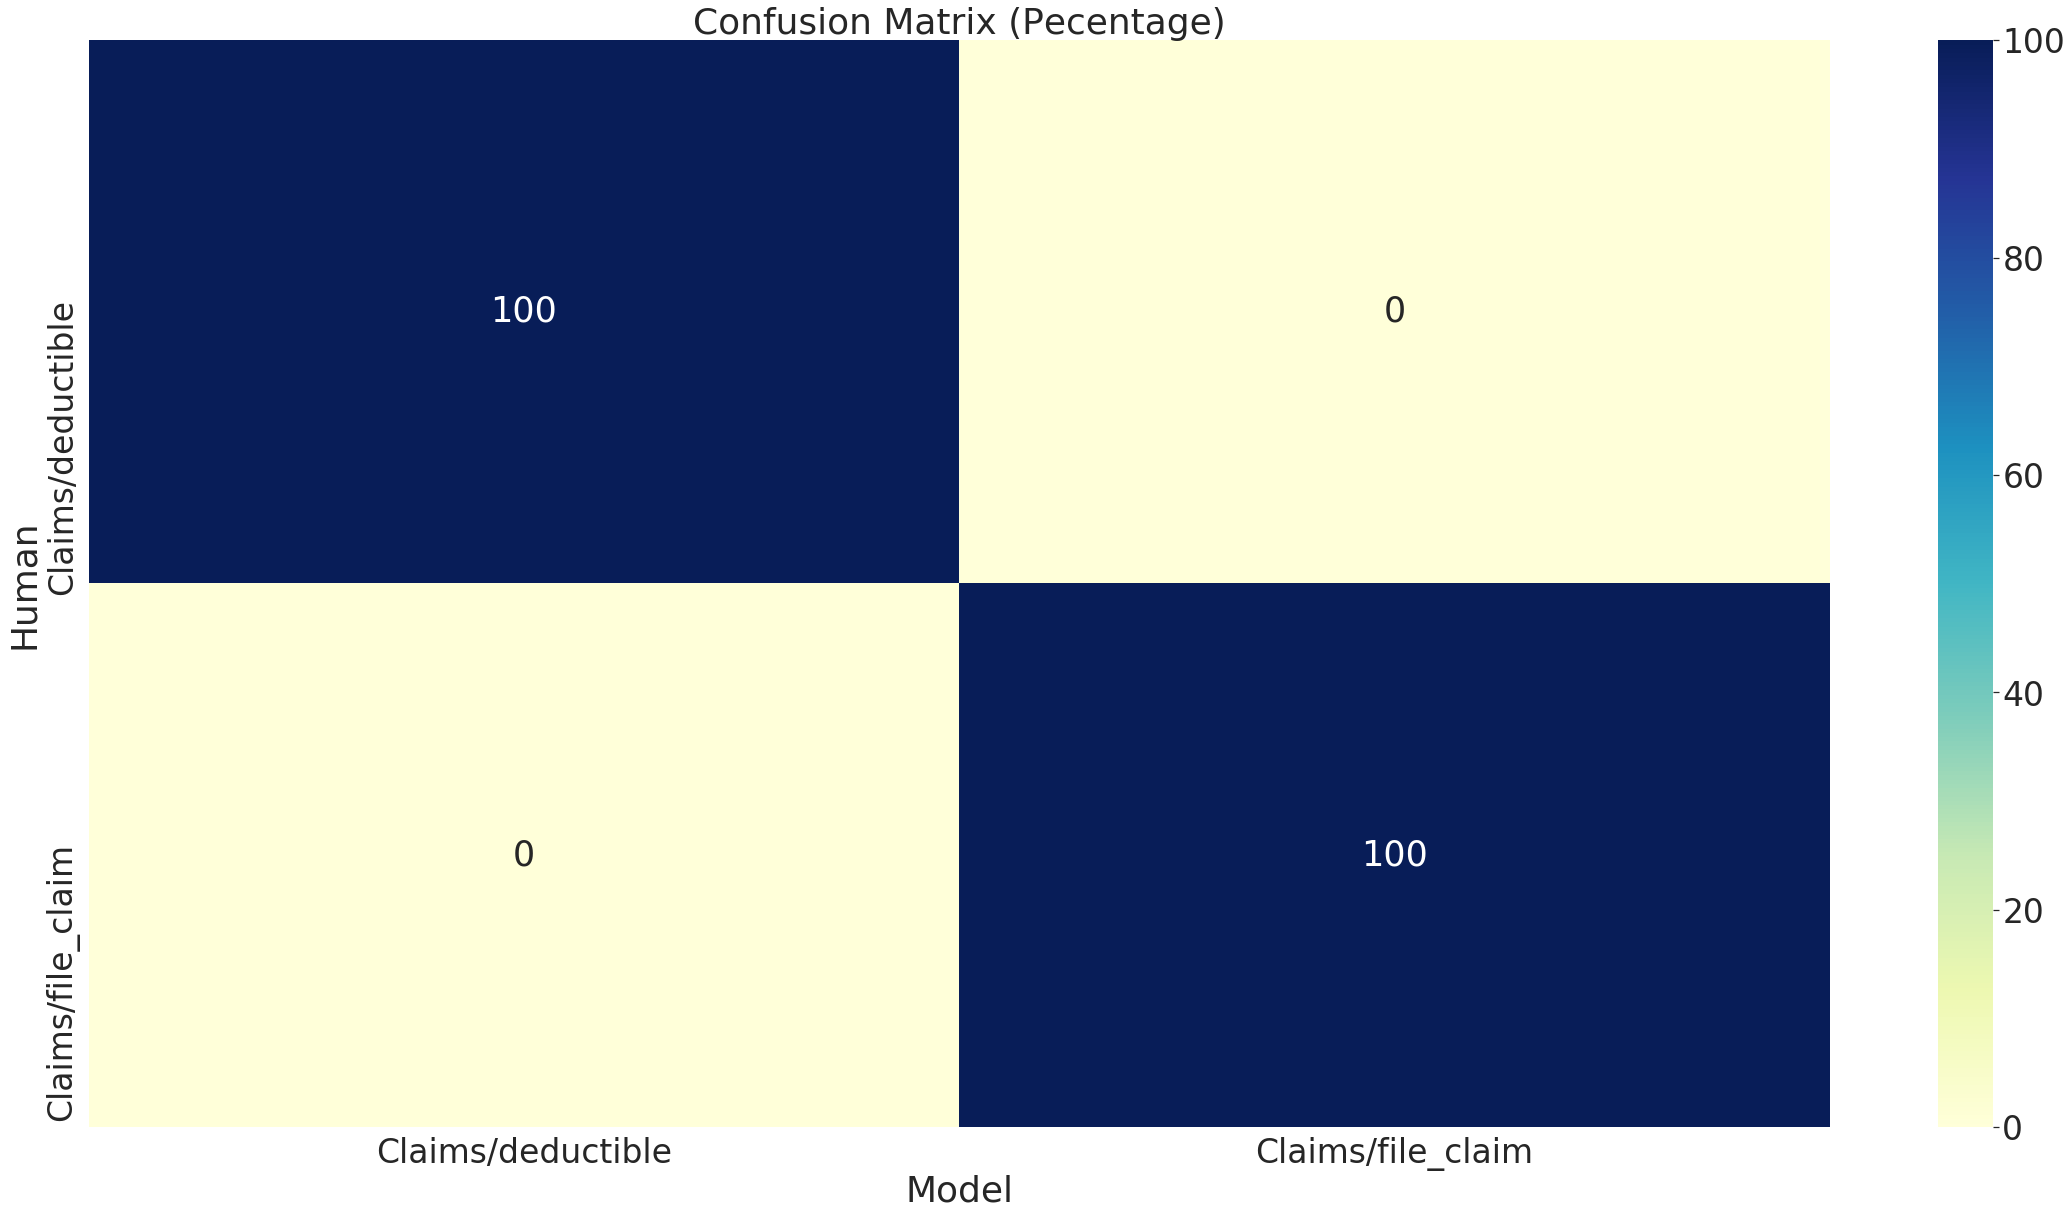

In [30]:
class_names = supported_category
cnf_matrix =confusion_matrix(test_labels,list(predicted),labels=class_names)
cnf_matrix_normalized = np.around(np.nan_to_num(cnf_matrix.astype('float') *100 / cnf_matrix.sum(axis=1)[:, np.newaxis]),0)

show_confusion_matrix(cnf_matrix,'Confusion Matrix (Count)','Model','Human',class_names)
show_confusion_matrix(cnf_matrix_normalized,'Confusion Matrix (Pecentage)','Model','Human',class_names)

In [31]:
# Define IAM role
import boto3
#from sagemaker import get_execution_role
#role = get_execution_role()
s3_client = boto3.client('s3')
bucket = 'ava-intentgateway'
prefix = 'vzw_claims_models'
model_type = 'scikit-learn-lr-multiclass'
model_version = '0.0.1'

model_file = '{}_opensource_v{}.model'.format(model_type,model_version)
featex_file = '{}_opensource_v{}.featex'.format(model_type,model_version)
labels_file = '{}_opensource_v{}.labels'.format(model_type,model_version)
labels_map = {k: v for k,v in enumerate(model.classes_)}

joblib.dump(model, 'models/'+model_file,protocol=2)
joblib.dump(featex, 'models/'+featex_file,protocol=2)
joblib.dump(labels_map, 'models/'+labels_file,protocol=2)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, model_file)).upload_file('models/'+model_file)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, featex_file)).upload_file('models/'+featex_file)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, labels_file)).upload_file('models/'+labels_file)